## EDA (duckdb)

In [1]:
import duckdb
from constants import DUCKDB_CLEAN_DATABASE, CLEAN_PARQUET_DATA_ROOT
from utils import get_total_size_GB
import os
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
sns.set_theme()

### Statistics before/after cleaning (working directly on parquet files with duckdb)

In [2]:
# Connect to DuckDB
con = duckdb.connect()

# Get row counts as DataFrames
count_before_df = con.execute("""
    SELECT COUNT(*) AS count_before 
    FROM 'data/task1/all/*/*.parquet';
""").df()

count_after_df = con.execute("""
    SELECT COUNT(*) AS count_after 
    FROM 'data/clean/*/*.parquet';
""").df()

count_before = count_before_df['count_before'][0]
count_after = count_after_df['count_after'][0]

rows_removed = count_before - count_after
percentage_removed = round((rows_removed / count_before) * 100, 2) if count_before else 0.0
summary_df = pd.DataFrame([{
    '#rows before': count_before,
    '#rows after': count_after,
    '#rows removed': rows_removed,
    'percentage removed': percentage_removed
}])

summary_df['#rows before'] = summary_df['#rows before'].apply(lambda x: f'{x:,}')
summary_df['#rows after'] = summary_df['#rows after'].apply(lambda x: f'{x:,}')
summary_df['#rows removed'] = summary_df['#rows removed'].apply(lambda x: f'{x:,}')
summary_df['percentage removed'] = summary_df['percentage removed'].apply(lambda x: f'{x}%')
display(summary_df)

,#rows before,#rows after,#rows removed,percentage removed
0,"1,781,713,266","1,723,441,060","58,272,206",3.27%


### Creating a duckdb database from parquet files

In [3]:
if not os.path.exists(DUCKDB_CLEAN_DATABASE):
    os.makedirs(os.path.dirname(DUCKDB_CLEAN_DATABASE), exist_ok=True)
    conn = duckdb.connect(DUCKDB_CLEAN_DATABASE)
    conn.execute(
        f"""
        CREATE TABLE data AS 
        SELECT * FROM '{CLEAN_PARQUET_DATA_ROOT}/**/*.parquet';
        """)

# File size of all parquet files vs the duck db database file
pq_files = glob(os.path.join(CLEAN_PARQUET_DATA_ROOT, '**', '*.parquet'), recursive=True)
pq_files_size = get_total_size_GB(pq_files)
print(f"Total size of parquet files: {pq_files_size} GB")
print(f"Total size of duckdb database: {os.path.getsize(DUCKDB_CLEAN_DATABASE) / (1024 * 1024 * 1024):.3f} GB")

conn = duckdb.connect(DUCKDB_CLEAN_DATABASE)

Total size of parquet files: 34.334 GB
Total size of duckdb database: 47.642 GB


In [4]:
conn.sql("""SELECT * FROM data""")

┌───────────┬─────────────────────┬─────────────────────┬─────────────────┬───────────────┬──────────────┬────────────────────┬──────────────┬─────────────┬───────┬─────────┬────────────┬──────────────┬───────────────────────┬──────────────┬──────────────────────┬─────────────┬──────────────────┬─────────────────┬───────────────────┬──────────────────┬───────┐
│ vendor_id │   pickup_datetime   │  dropoff_datetime   │ passenger_count │ trip_distance │ rate_code_id │ store_and_fwd_flag │ payment_type │ fare_amount │ extra │ mta_tax │ tip_amount │ tolls_amount │ improvement_surcharge │ total_amount │ congestion_surcharge │ airport_fee │ pickup_longitude │ pickup_latitude │ dropoff_longitude │ dropoff_latitude │ year  │
│   int8    │    timestamp_ns     │    timestamp_ns     │      uint8      │     float     │    uint8     │        int8        │    uint8     │    float    │ float │  float  │   float    │    float     │         float         │    float     │        float         │    float 

## Number of trips per year

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Text(0, 0.5, 'Trip Count')

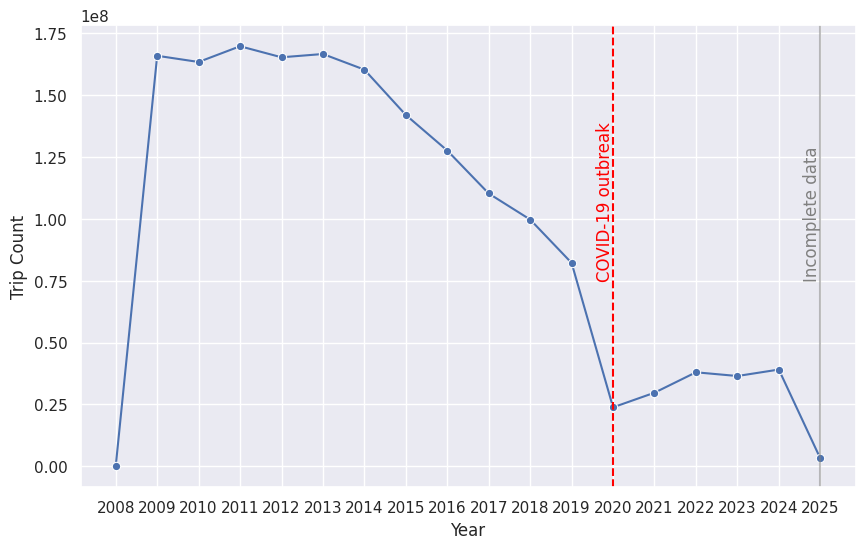

In [5]:
df = conn.sql(
    """
    SELECT 
        EXTRACT(year FROM pickup_datetime) AS year,
        COUNT(*) AS trip_count
    FROM data
    GROUP BY EXTRACT(year FROM pickup_datetime)
    ORDER BY year;
    """
).df()

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='trip_count', marker='o')
ax.set_xticks(df['year'])
# add vline indicating covid 19
ax.axvline(x=2020, color='red', linestyle='--')
ax.text(2019.8, 0.75e8, 'COVID-19 outbreak', color='red', fontsize=12, ha='center', va='bottom', rotation=90)
# ad region from 2025 onwards indicating incomplete data
ax.axvline(2025, color='gray', alpha=0.5)
ax.text(2024.8, 0.75e8, 'Incomplete data', color='gray', fontsize=12, ha='center', va='bottom', rotation=90)
ax.set_xlabel('Year')
ax.set_ylabel('Trip Count')

## Average number of trips per day of week

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

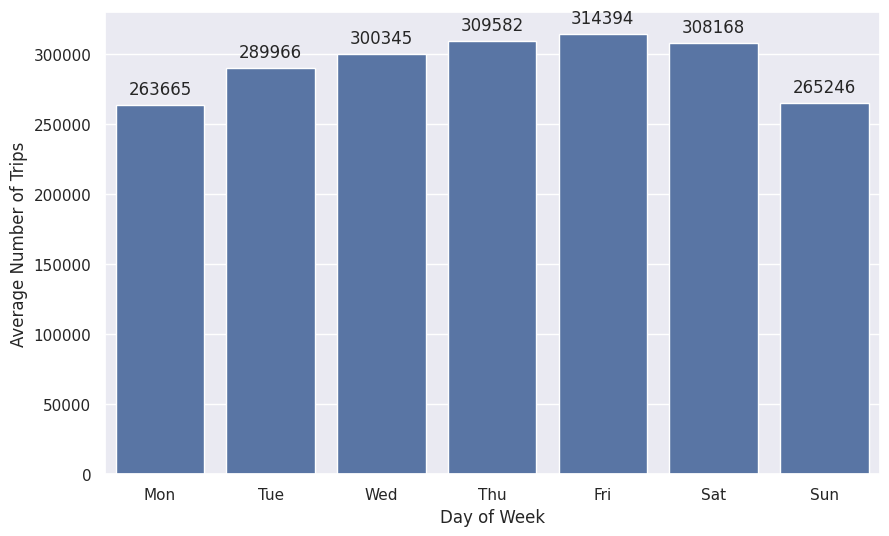

In [5]:
## number of trips per year
trips_per_day = conn.sql(
    """
    WITH trips_per_day AS (
        SELECT 
            CAST(pickup_datetime AS DATE) AS trip_date,
            (EXTRACT(dow FROM pickup_datetime) + 6) % 7 AS day_of_week, -- by default, 0 is Sunday
            COUNT(*) AS trips
        FROM data
        GROUP BY trip_date, day_of_week
    )
    SELECT 
        day_of_week,
        AVG(trips) AS avg_trips
    FROM trips_per_day
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """
).df()
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=trips_per_day, x='day_of_week', y='avg_trips')
# map x ticks to day names
ax.set_xticks(trips_per_day['day_of_week'])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Number of Trips')
for i, row in trips_per_day.iterrows():
    ax.text(row['day_of_week'], row['avg_trips'] + 0.5e4, f"{int(row['avg_trips'])}", ha='center', va='bottom')

## Some aggregate statistics

In [4]:
df = conn.sql(
    """
    SELECT
        ROUND(MEDIAN(DATE_DIFF('minute', pickup_datetime, dropoff_datetime))) AS "Median trip duration [min]",
        ROUND(MEDIAN(fare_amount)) AS "Median fare amount [$]",
        MODE(passenger_count) AS "Most common passenger count",
        MODE(payment_type) AS "Most common payment type",
    FROM data;
    """
).df()

payment_type_mapping = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
}
df['Most common payment type'] = df['Most common payment type'].map(payment_type_mapping)
display(df)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Median trip duration [min],Median fare amount [$],Most common passenger count,Most common payment type
0,11.0,9.0,1,Credit Card


### Average tip

In [4]:
df = conn.sql(
    """
    SELECT 
        ROUND(AVG(tip_amount / fare_amount * 100)) AS "Average tip [%]"
    FROM data
    WHERE tip_amount > 0 AND fare_amount > 0;
    """
).df()
display(df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Average tip [%]
0,22.0
